<a href="https://colab.research.google.com/github/dajebbar/Flowers-Recognition-with-PyTorch/blob/main/Flowers_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the dataset from kaggle
Using `opendatasets` and download the dataset [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)

In [9]:
!pip install opendatasets --upgrade --quiet

In [10]:
import opendatasets as od

url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

od.download(url)

  2%|▏         | 9.00M/450M [00:00<00:05, 89.2MB/s]

100%|██████████| 450M/450M [00:02<00:00, 206MB/s]


In [11]:
import os

data_dir = './flowers-recognition/flowers'

os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'flowers', 'daisy']

In [12]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [13]:
os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'daisy']

## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [14]:
from torchvision.datasets import ImageFolder

In [16]:
dataset = ImageFolder(data_dir)

In [17]:
len(dataset)

4323

In [18]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F1856CEAC10>, 0)

In [19]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [20]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

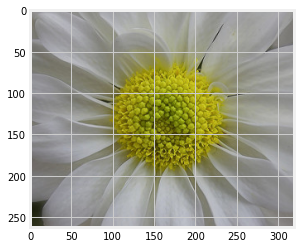

In [22]:
img, _ = dataset[0]
plt.imshow(img)

In [23]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(224),
                                            tt.RandomCrop(224),
                                            tt.ToTensor()]))

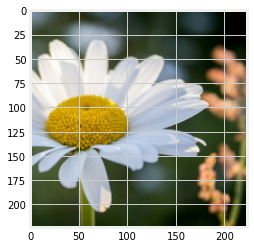

In [25]:
img, _ = dataset[170]
plt.imshow(img.permute(1,2,0))

In [27]:
val_pct = .1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [28]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(3891, 432)

In [30]:
from torch.utils.data import  DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)